# Temperatire Analysis with Pyspark

## 1. Create SparkSession

In [2]:
from pyspark.sql import SparkSession 

spark = SparkSession \
        .builder \
        .appName("TemperatureAnalysis") \
        .getOrCreate()

## 2. Load and Explore dataset

In [57]:
# Shortcut way: df = spark.read.csv("global_temperatures.csv", inferSchema=True, header=True)

# inferSchema is used to automatically infer the data types of each column. Don't use it on large datasets

# Standard way
df = spark.read \
    .format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load("./data/global_temperatures.csv")

### Explore Dataset

In [58]:
df.printSchema()
df.show(5)

root
 |-- dt: date (nullable = true)
 |-- AverageTemperature: double (nullable = true)
 |-- AverageTemperatureUncertainty: double (nullable = true)
 |-- Country: string (nullable = true)

+----------+------------------+-----------------------------+-------+
|        dt|AverageTemperature|AverageTemperatureUncertainty|Country|
+----------+------------------+-----------------------------+-------+
|1819-05-01|              NULL|                         NULL|   Asia|
|1820-01-01|              NULL|                         NULL|   Asia|
|2013-09-01|              NULL|                         NULL|   Asia|
|1818-03-01|              NULL|                         NULL|   Asia|
|1871-12-01|              NULL|                         NULL|   Chad|
+----------+------------------+-----------------------------+-------+
only showing top 5 rows



## 3. Data Cleaning

### Count Missing Values

In [6]:
from pyspark.sql.functions import count, when, isnull

df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+---+------------------+-----------------------------+-------+
| dt|AverageTemperature|AverageTemperatureUncertainty|Country|
+---+------------------+-----------------------------+-------+
|  0|             32651|                        31912|      0|
+---+------------------+-----------------------------+-------+



In [29]:
# Drop rows with missing values
# df = df.filter(df["AverageTemperature"].isNotNull())
# df = df.filter(df["AverageTemperatureUncertainty"].isNotNull())

df = df.dropna()
df.show(5)

+----------+------------------+-----------------------------+-------+
|        dt|AverageTemperature|AverageTemperatureUncertainty|Country|
+----------+------------------+-----------------------------+-------+
|1836-08-01|            24.997|                          2.0|  Burma|
|1828-10-01|            23.275|                          2.0|  Egypt|
|1834-05-01|            27.213|                          2.0|  Egypt|
|1842-03-01|             7.851|                          2.0|  Italy|
|1854-07-01|            30.018|                          2.0|  Libya|
+----------+------------------+-----------------------------+-------+
only showing top 5 rows



## 4. Descriptive Statics

In [8]:
df.describe().show()

+-------+------------------+-----------------------------+-----------+
|summary|AverageTemperature|AverageTemperatureUncertainty|    Country|
+-------+------------------+-----------------------------+-----------+
|  count|            544811|                       544811|     544811|
|   mean|17.193354232935935|           1.0191898511593562|       NULL|
| stddev|10.953966445121132|            1.202633603844475|       NULL|
|    min|           -37.658|         0.052000000000000005|Afghanistan|
|    max| 38.84200000000001|                       15.003|      Åland|
+-------+------------------+-----------------------------+-----------+



## 5. Data Visualization 

### Average temperature by year

In [30]:
from pyspark.sql.functions import year, mean

df = df.withColumn("year", year("dt"))
df_year_avg = df.groupBy("year").agg(
            mean('AverageTemperature').alias('avg_temperature')
            ).orderBy("year")

df_year_avg.show(7)

+----+------------------+
|year|   avg_temperature|
+----+------------------+
|1743|           5.18414|
|1744|         9.8378975|
|1745|1.3871250000000002|
|1750| 9.129352727272725|
|1751|         9.1673875|
|1752| 4.413386666666666|
|1753| 8.870820754716979|
+----+------------------+
only showing top 7 rows



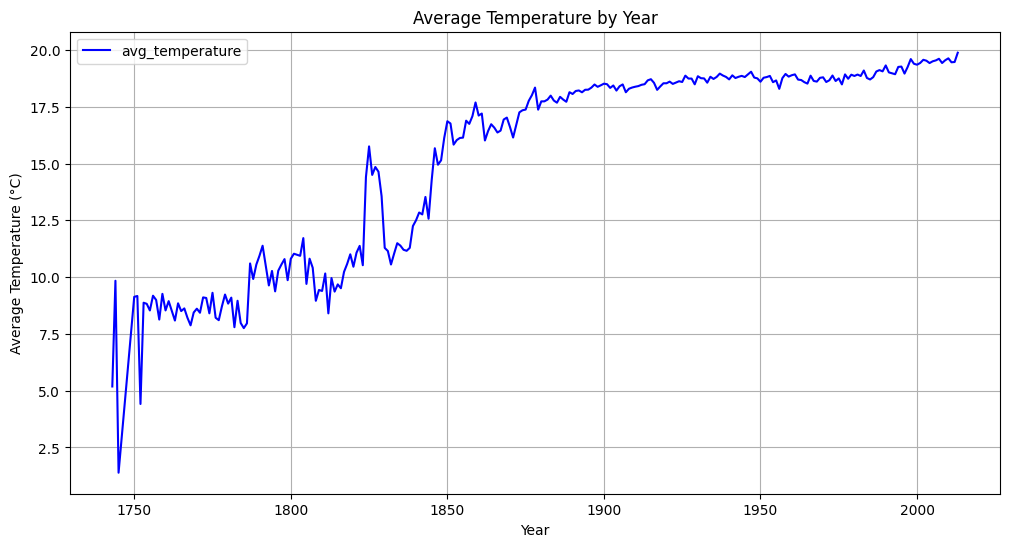

In [10]:
import matplotlib.pyplot as plt

pandas_df_year = df_year_avg.toPandas()

pandas_df_year.plot(x="year", y="avg_temperature", kind="line", color="blue", figsize=(12, 6))
plt.xlabel("Year")
plt.ylabel("Average Temperature (°C)")
plt.title("Average Temperature by Year")
plt.grid(True)
plt.show()

### Top 20 Average temperature by Country

In [11]:

df_country_avg = df.groupBy("Country").agg(
            mean('AverageTemperature').alias('avg_temperature')
            ).orderBy("avg_temperature", ascending=False)

df_country_avg.show(7)

+--------------------+------------------+
|             Country|   avg_temperature|
+--------------------+------------------+
|            Djibouti|  28.8166025331725|
|                Mali|28.441976570820014|
|        Burkina Faso|28.083506760411037|
|             Senegal| 27.96737500000001|
|               Aruba|27.920390220517746|
|United Arab Emirates| 27.69399470058293|
|          Mauritania|27.620255504352283|
+--------------------+------------------+
only showing top 7 rows



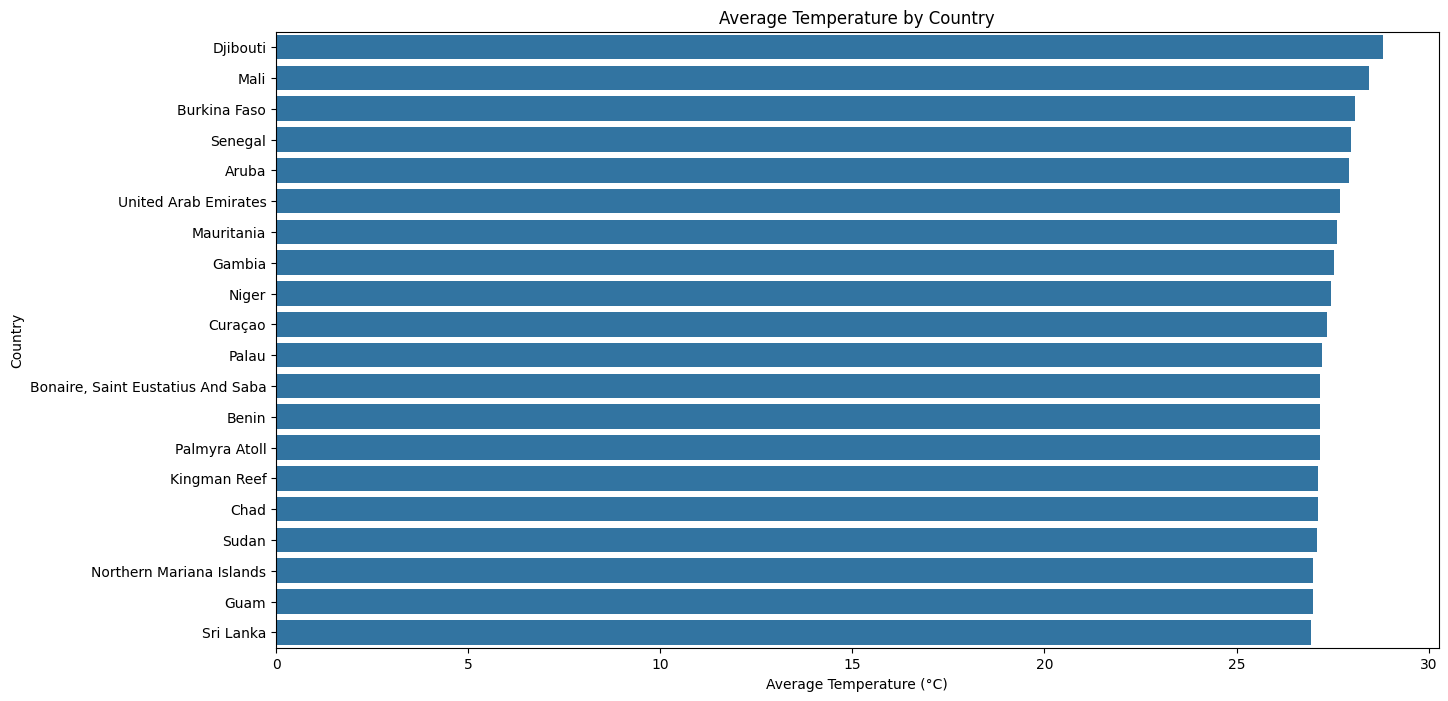

In [12]:
import seaborn as sns

pandas_df_country = df_country_avg.toPandas()

plt.figure(figsize=(15, 8))
sns.barplot(x="avg_temperature", y="Country", data=pandas_df_country.head(20))  # Top 20 countries
plt.xlabel("Average Temperature (°C)")
plt.ylabel("Country")
plt.title("Average Temperature by Country")
plt.show()

### Temperature and Uncertainty by Year

In [13]:
df_yearly_stats = df.groupBy("year").agg(
    mean('AverageTemperature').alias('avg_temperature'),
    mean('AverageTemperatureUncertainty').alias('avg_temperature_uncertainty'),
).orderBy("year")

df_yearly_stats.show(7)

+----+------------------+---------------------------+
|year|   avg_temperature|avg_temperature_uncertainty|
+----+------------------+---------------------------+
|1743|           5.18414|                    2.18352|
|1744|         9.8378975|         2.1363025000000007|
|1745|1.3871250000000002|         1.9605900000000003|
|1750| 9.129352727272725|         2.1037945454545457|
|1751|         9.1673875|         2.0532175000000006|
|1752| 4.413386666666666|          2.197893333333333|
|1753| 8.870820754716979|         3.7469182389937106|
+----+------------------+---------------------------+
only showing top 7 rows



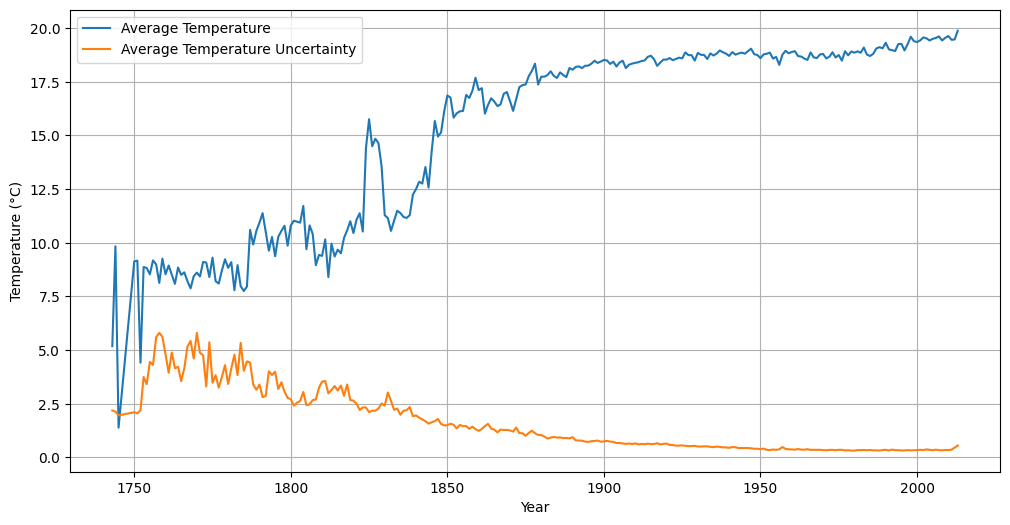

In [14]:
pandas_df_yearly_stats = df_yearly_stats.toPandas()

plt.figure(figsize=(12, 6))
plt.plot(pandas_df_yearly_stats["year"],
         pandas_df_yearly_stats["avg_temperature"],
         label="Average Temperature")
plt.plot(pandas_df_yearly_stats["year"],
         pandas_df_yearly_stats["avg_temperature_uncertainty"],
         label="Average Temperature Uncertainty")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.legend()
plt.show()

### Rolling Average of Temperature

In [34]:
from pyspark.sql.window import Window
from pyspark.sql.functions import avg
# Define a window of for a 3-year rolling average
window_spec = Window.orderBy('dt').rowsBetween(-2, 0)  # 2 rows before the current one, plus the current row

# Add a column for the rolling average of the temperature
df = df.withColumn('rolling_avg_temp', avg('AverageTemperature').over(window_spec))

df.select('dt', 'AverageTemperature', 'rolling_avg_temp').show()

+----------+------------------+------------------+
|        dt|AverageTemperature|  rolling_avg_temp|
+----------+------------------+------------------+
|1743-11-01|            -1.444|            -1.444|
|1743-11-01|             8.009|            3.2825|
|1743-11-01|             1.898|             2.821|
|1743-11-01| 6.507000000000001| 5.471333333333334|
|1743-11-01|             7.556| 5.320333333333334|
|1743-11-01|             5.468| 6.510333333333333|
|1743-11-01|            -1.794|3.7433333333333336|
|1743-11-01|2.4819999999999998|             2.052|
|1743-11-01|4.3839999999999995|1.6906666666666663|
|1743-11-01|5.6450000000000005| 4.170333333333333|
|1743-11-01|             7.397| 5.808666666666667|
|1743-11-01|            10.203| 7.748333333333334|
|1743-11-01| 7.729999999999999| 8.443333333333333|
|1743-11-01|3.4150000000000005|             7.116|
|1743-11-01|             5.431| 5.525333333333333|
|1743-11-01|             0.936| 3.260666666666667|
|1743-11-01|6.5920000000000005|

### Average Temperature difference by year

In [52]:
df_year_avg = df.groupBy("year").agg(
    round(avg('AverageTemperature'), 2).alias('avg_temperature')
).orderBy("year")

window_spec = Window.orderBy('year')

df_diff = df_year_avg.withColumn('prev_avg_temp', lag('avg_temperature', 1).over(window_spec))

df_diff = df_diff.withColumn('avg_temp_diff', round(df_diff['avg_temperature'] - df_diff['prev_avg_temp'], 2))

df_diff.show(10)

+----+---------------+-------------+-------------+
|year|avg_temperature|prev_avg_temp|avg_temp_diff|
+----+---------------+-------------+-------------+
|1743|           5.18|         NULL|         NULL|
|1744|           9.84|         5.18|         4.66|
|1745|           1.39|         9.84|        -8.45|
|1750|           9.13|         1.39|         7.74|
|1751|           9.17|         9.13|         0.04|
|1752|           4.41|         9.17|        -4.76|
|1753|           8.87|         4.41|         4.46|
|1754|           8.82|         8.87|        -0.05|
|1755|           8.53|         8.82|        -0.29|
|1756|           9.18|         8.53|         0.65|
+----+---------------+-------------+-------------+
only showing top 10 rows



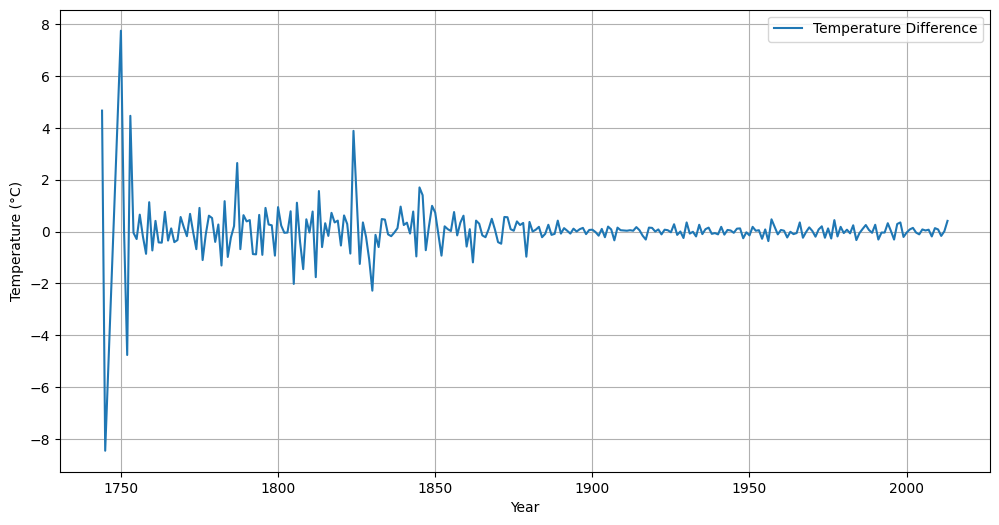

In [53]:
pandas_diff = df_diff.toPandas()

plt.figure(figsize=(12, 6))
plt.plot(pandas_diff["year"], pandas_diff["avg_temp_diff"], label="Temperature Difference")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.legend()
plt.show()

### Filter Data After year 1980

In [61]:
df_filtered = df_year_avg.filter(df_diff["year"] > 1980)
df_filtered.show()

+----+---------------+
|year|avg_temperature|
+----+---------------+
|1981|          18.92|
|1982|          18.85|
|1983|          19.09|
|1984|          18.76|
|1985|           18.7|
|1986|           18.8|
|1987|          19.05|
|1988|          19.11|
|1989|          19.06|
|1990|          19.32|
|1991|          19.01|
|1992|          18.97|
|1993|          18.93|
|1994|          19.25|
|1995|          19.27|
|1996|          18.96|
|1997|          19.25|
|1998|           19.6|
|1999|          19.39|
|2000|          19.35|
+----+---------------+
only showing top 20 rows



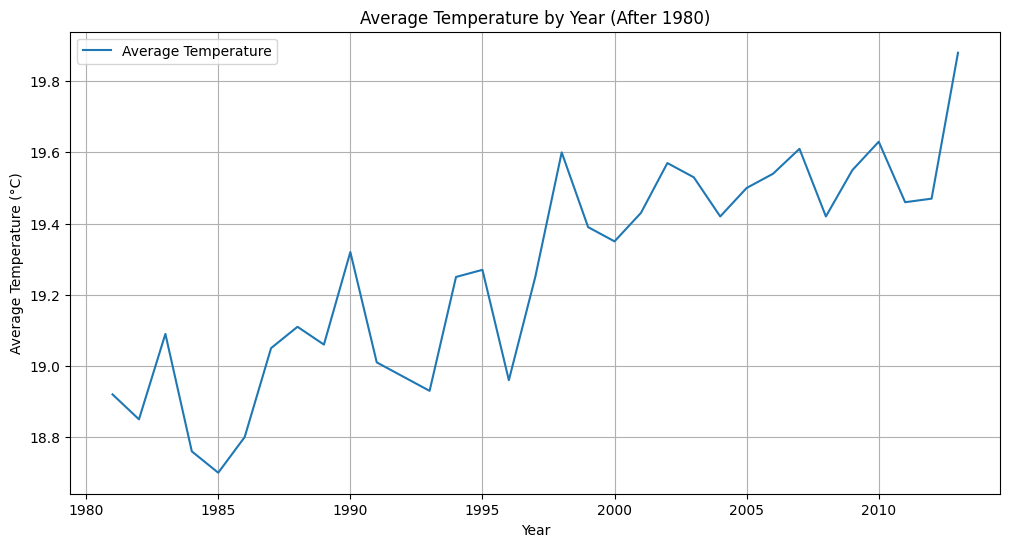

In [62]:
# Plot filtered data after 1980
pandas_df_filtered = df_filtered.toPandas()

plt.figure(figsize=(12, 6))
plt.plot(pandas_df_filtered["year"], pandas_df_filtered["avg_temperature"], label="Average Temperature")
plt.xlabel("Year")
plt.ylabel("Average Temperature (°C)")
plt.title("Average Temperature by Year (After 1980)")
plt.grid(True)
plt.legend()
plt.show()